In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

from PIL import Image
import pickle
import os

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder

import timm
from timm import create_model
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from prophet import Prophet

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have one GPU
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.
GPU Device Name: Tesla T4


# Load meteorological and image dataset


In [ ]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  df.set_index('Timestamp', inplace=True) # set timestamp as index
  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

In [ ]:
# Load Meteorological Dataset
data = pd.read_csv("/content/drive/MyDrive/Numerical Dataset Curation/Meteorological_Data.csv")
df=preprocess_dataframe(data)

cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]','Avg BRBG Total Cloud Cover [%]','Avg Azimuth Angle [degrees]','Avg Albedo (CMP11)','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]']
data_df=df.loc[:, cols_to_keep]
data_df = data_df.reset_index()
data_df = data_df.rename(columns={"Timestamp": "ds", "Avg Global CMP22 (vent/cor) [W/m^2]": "y"})

In [ ]:
# Load Image Dataset
csv_path = '/content/drive/My Drive/Image Dataset Curation/Image_Dataset_Final.csv'
img_df = pd.read_csv(csv_path)

# Sort dataset by datetime
img_df['datetime'] = pd.to_datetime(img_df['datetime'])
img_df = img_df.sort_values(by='datetime')
img_df.set_index('datetime', inplace=True)
img_df.head()

,image_path,Avg Global CMP22 (vent/cor) [W/m^2]
datetime,,
2021-10-08 07:00:00,/content/drive/MyDrive/Image Dataset Curation/...,63.8407
2021-10-08 08:00:00,/content/drive/MyDrive/Image Dataset Curation/...,176.1522
2021-10-08 09:00:00,/content/drive/MyDrive/Image Dataset Curation/...,361.7695
2021-10-08 10:00:00,/content/drive/MyDrive/Image Dataset Curation/...,582.2481
2021-10-08 11:00:00,/content/drive/MyDrive/Image Dataset Curation/...,632.4995


In [ ]:
# image path
# img = img_df["image_path"][1]
# print("Image path:\t", img)

# load image and display
# im = Image.open(img)
# im

In [ ]:
# Validate if both datasets have common timestamps

In [ ]:
def split_dataset(df):
  # Dataset split into training, validation, and testing
  train_percentage = 0.6
  val_percentage = 0.2
  test_percentage = 0.2

  train_index = int(train_percentage * len(df))
  val_index = int((train_percentage + val_percentage) * len(df))

  # Split data
  train_df = df[:train_index]
  val_df = df[train_index:val_index]
  test_df = df[val_index:]

  return train_df, val_df, test_df

In [ ]:
# Split numeric data
train_df, val_df, test_df = split_dataset(data_df)

# Split image data
img_train_df, img_val_df, img_test_df = split_dataset(img_df)

### Load both saved models to forecast on test dataset

In [ ]:
# Load prophet model
with open('/content/drive/MyDrive/Forecasting Models/Prophet/Prophetbest_model.pkl', 'rb') as f:
    prophet_model = pickle.load(f)

# Predict using prophet
predict = prophet_model.predict(test_df)
predicted_values = predict[['ds', 'yhat']]
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Forecast using prophet
future_df = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future_df)
forecasted_values = forecast[['ds', 'yhat']]

In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataframe.iloc[idx]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        target = torch.tensor(float(self.dataframe.iloc[idx]['Avg Global CMP22 (vent/cor) [W/m^2]']))
        return img, target

In [ ]:
# Load Inception model
inception_model = timm.create_model('inception_v4', pretrained=True).to(device)
# Modify the last layer for regression
num_features = inception_model.last_linear.in_features
inception_model.last_linear = nn.Linear(num_features, 1)  # 1 output for regression
inception_model = inception_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(inception_model.parameters(), lr=1e-4)

# Define transforms
config = resolve_data_config({}, model=inception_model)
transform = create_transform(**config)

# Create custom datasets and data loaders
batch_size = 32

train_dataset = CustomDataset(img_train_df, transform=transform)
val_dataset = CustomDataset(img_val_df, transform=transform)
test_dataset = CustomDataset(img_test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
# Load the state dictionary
checkpoint = torch.load('/content/drive/MyDrive/Forecasting Models/Inception_V4/model_F_checkpoint.pth')
inception_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Forecast using Inception
inception_model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = inception_model(images)
        predictions.extend(outputs.cpu().numpy())
        actual_values.extend(targets.cpu().numpy())

# Convert the lists to NumPy arrays
predictions = np.array(predictions)
actual_values = np.array(actual_values)

In [ ]:
# predictions

### Hybrid architecture

In [ ]:
# Handling predictions on test meteorological dataset

test_df['ds'] = pd.to_datetime(test_df['ds'])
test_df = test_df.sort_values(by='ds')
test_df.set_index('ds', inplace=True)
predicted_values['ds'] = pd.to_datetime(predicted_values['ds'])
predicted_values = predicted_values.sort_values(by='ds')
predicted_values.set_index('ds', inplace=True)

test_df['yhat'] = predicted_values['yhat']

predicted_values
forecasted_values
test_df.head()

modelA = test_df[["y","yhat"]]
modelA.head()

<ipython-input-17-8c177b506745>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])
<ipython-input-17-8c177b506745>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_values['ds'] = pd.to_datetime(predicted_values['ds'])


,y,yhat
ds,,
2023-06-09 10:00:00,853.9224,509.184778
2023-06-09 11:00:00,909.8427,610.936542
2023-06-09 12:00:00,457.6990,659.550948
2023-06-09 13:00:00,637.9514,642.501013
2023-06-09 14:00:00,490.3814,566.314841


In [ ]:
# Handling predictions on test image dataset
img_test_df["y_pred"] = predictions
img_test_df["y_true"] = actual_values

modelB = img_test_df[["y_true","y_pred"]]
modelB.head()

<ipython-input-18-753f2c6e5860>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_test_df["y_pred"] = predictions
<ipython-input-18-753f2c6e5860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_test_df["y_true"] = actual_values


,y_true,y_pred
datetime,,
2023-06-06 19:00:00,79.272903,78.553307
2023-06-07 05:00:00,7.651700,5.429838
2023-06-07 06:00:00,69.000099,6.400939
2023-06-07 07:00:00,249.413101,4.528181
2023-06-07 08:00:00,485.230194,360.330231


In [ ]:
# Inner join of both datasets
merged_df = pd.merge(modelA, modelB, left_index=True, right_index=True, how='inner')
merged_df.shape

(1453, 4)

In [ ]:
# Average of both predictions
merged_df["avg_pred"] = (merged_df['y_pred'] + merged_df['yhat']) / 2

merged_df.head()

,y,yhat,y_true,y_pred,avg_pred
2023-06-09 10:00:00,853.9224,509.184778,853.922424,670.666199,589.925489
2023-06-09 11:00:00,909.8427,610.936542,909.842712,851.829407,731.382974
2023-06-09 12:00:00,457.6990,659.550948,457.699005,627.375183,643.463065
2023-06-09 13:00:00,637.9514,642.501013,637.951416,66.642525,354.571769
2023-06-09 14:00:00,490.3814,566.314841,490.381409,371.404175,468.859508


In [ ]:
# Calculate Mean Squared Error (MSE)
def get_metrics(true_values, predicted_values):
    # Calculate Mean Squared Error (MSE
    mse = mean_squared_error(true_values, predicted_values)
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return mse, rmse

In [ ]:
# Calculate metrics for numeric, image and average prediction

# Prophet metrics
mse_A, rmse_A = get_metrics(merged_df["y_true"], merged_df["yhat"])

# Inception metrics
mse_B, rmse_B = get_metrics(merged_df["y_true"], merged_df["y_pred"])

# Hybrid metrics
mse_C, rmse_C = get_metrics(merged_df["y_true"], merged_df["avg_pred"])

# print("Model A (Prophet):")
# print(f"Mean Squared Error (MSE): {mse_A}")
# print(f"Root Mean Squared Error (RMSE): {rmse_A}")

# print("Model B (Inception):")
# print(f"Mean Squared Error (MSE): {mse_B}")
# print(f"Root Mean Squared Error (RMSE): {rmse_B}")

# print("Hybrid Model:")
# print(f"Mean Squared Error (MSE): {mse_C}")
# print(f"Root Mean Squared Error (RMSE): {rmse_C}")

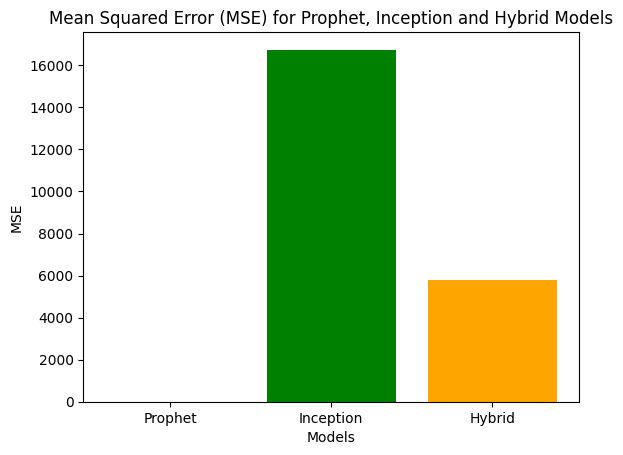

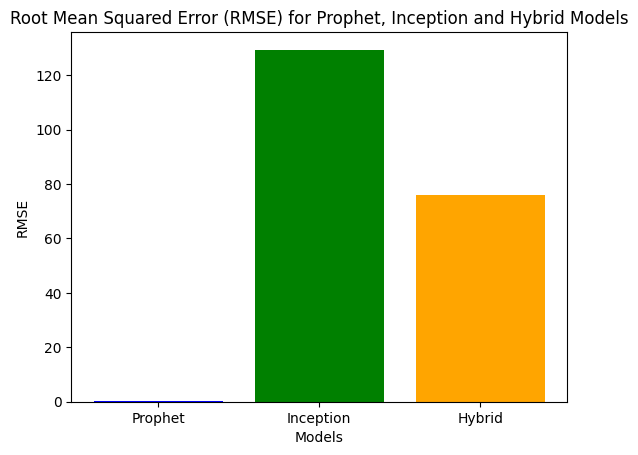

In [ ]:
# Plotting the metrics
models = ['Prophet', 'Inception', 'Hybrid']
mse_values = [mse_A, mse_B, mse_C]
rmse_values = [rmse_A, rmse_B, rmse_C]

# Plotting Mean Squared Error (MSE)
plt.bar(models, mse_values, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) for Prophet, Inception and Hybrid Models')
plt.show()

# Plotting Root Mean Squared Error (RMSE)
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) for Prophet, Inception and Hybrid Models')
plt.show()


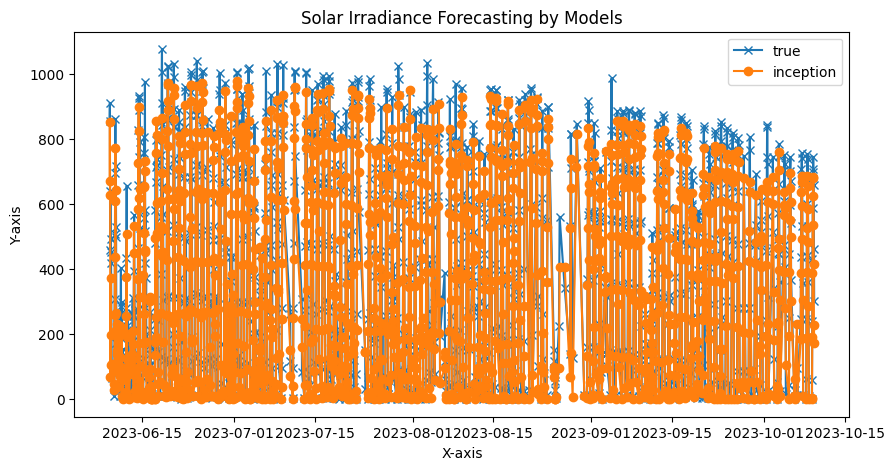

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(merged_df.index, merged_df['y_true'], label='true', marker='x')
plt.plot(merged_df.index, merged_df['y_pred'], label='inception', marker='o')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Solar Irradiance Forecasting by Models')
plt.legend()

# Show the plot
plt.show()



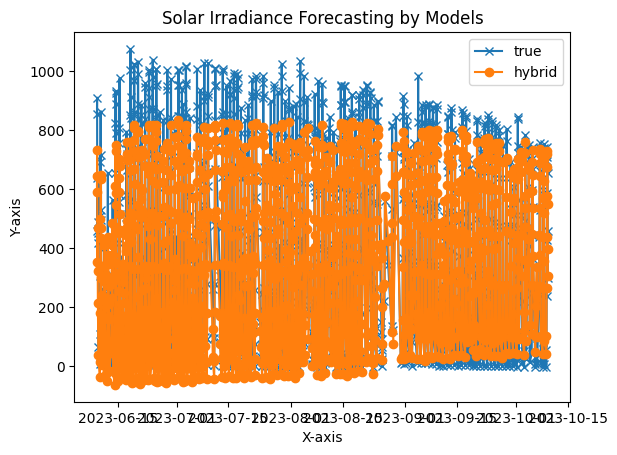

In [ ]:
# Plotting all three columns against the X-axis
# plt.figure(figsize=(20, 20))
plt.plot(merged_df.index, merged_df['y_true'], label='true', marker='x')
# plt.plot(merged_df.index, merged_df['yhat'], label='prophet', marker='o')
# plt.plot(merged_df.index, merged_df['y_pred'], label='inception', marker='o')
plt.plot(merged_df.index, merged_df['avg_pred'], label='hybrid', marker='o')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Solar Irradiance Forecasting by Models')
plt.legend()

# Show the plot
plt.show()